In [1]:
import pymongo
from pymongo import MongoClient
import pandas as pd
import json
import mysql.connector
from datetime import datetime
from time import time
import numpy as np
import matplotlib.pyplot as plt

In [2]:
host_ = 'localhost'
user_ = 'gg'
password_ = 'data2022'
puerto_ = 27017

Conexión a MySQL

In [3]:
conn = mysql.connector.connect(host=host_, user=user_,  
                        password=password_, database='METEO')
conn.autocommit = True
cursor = conn.cursor(buffered=True)

Conexión a MongoDB

In [4]:
client = MongoClient(host_,puerto_)
db = client['METEO']
print(db)

Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), 'METEO')


Número de veces que queremos realizar la misma consulta:

In [5]:
nro_iter = 1000 # número de iteraciones para las pruebas

Función para realizar un gráfico rápido de un boxplot

In [32]:
def box_plots(lsql,lnosql,name='compara'):
    fig,ax = plt.subplots(1,2,figsize=(10,8))
    ax[0].boxplot(lsql)
    ax[0].set_ylabel('Segundos')
    ax[0].set_xlabel('SQL')
    ax[1].boxplot(lnosql)
    ax[1].set_ylabel('Segundos')
    ax[1].set_xlabel('No SQL')
    fig.savefig('query'+name+'.pdf',bbox_inches='tight')

## Pruebas de performance

### Primer consulta: 

Obtener todos los datos entre las latitudes $26^oS$ y $31^oS$ y las longitudes $58^o$ y $63^oO$.

In [ ]:
sql1 = "select * from INFO_METEO3 WHERE (latitud BETWEEN -31 and -26) AND (longitud BETWEEN -63 and -58)"
l_sql = np.zeros(nro_iter)
for i in range(0,nro_iter):
    t11 = time()
    cursor.execute(sql1)
    t22 = time()
    #aux = t22-t11
    l_sql[i] = t22-t11


In [8]:
np.savetxt('query1_sql.txt',np.array(l_sql))

In [12]:
l_nosql = np.zeros(nro_iter)
for i in range(0,nro_iter):
    t11 = time()
    result = db.INFO_METEO3.find({"$and":[{"Lat" : { "$gte": -31, "$lte": -26}},{"Lon" : { "$gte": -63, "$lte": -58}}]})
    t22 = time()
    l_nosql[i] = t22-t11

tot_nosql = sum(l_nosql)
pro_nosql = tot_nosql/nro_iter

In [13]:
np.savetxt('query1_nosql.txt',np.array(l_nosql))

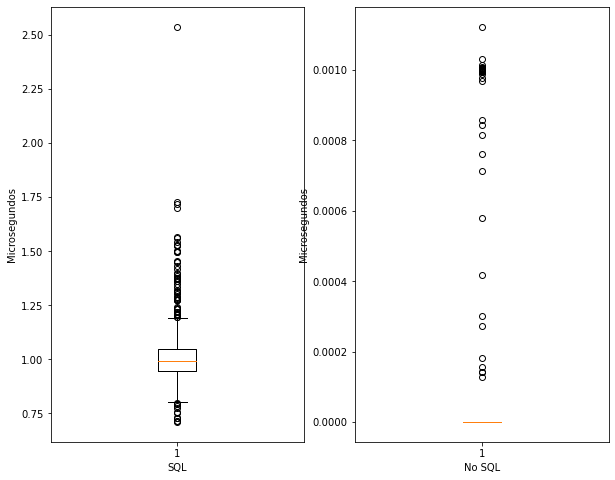

In [14]:
box_plots(l_sql,l_nosql,name='1')

### Segunda consulta

Obtener todos los datos entre el 15 y 27 de Febrero de 1979.

In [22]:
sql1 = "SELECT * FROM INFO_METEO3 WHERE Date(Fechas) Between '1979/02/15' AND '1979/02/28'"
l_sql = np.zeros(nro_iter)
for i in range(0,nro_iter):
    t11 = time()
    cursor.execute(sql1)
    t22 = time()
    l_sql[i] = t22-t11
    
tot_sql = sum(l_sql)
pro_sql = tot_sql/nro_iter

In [23]:
np.savetxt('query2_sql.txt',np.array(l_sql))

In [24]:
l_nosql = np.zeros(nro_iter)
for i in range(0,nro_iter):
    t11 = time()
    result = db.INFO_METEO3.find({"Fechas_dt":{"$gt":datetime(1979, 2, 2,0,0,0,0),"$lt":datetime(1979, 2, 25,0,0,0,0)}})
    t22 = time()
    l_nosql[i] = t22-t11

tot_nosql = sum(l_nosql)
pro_nosql = tot_nosql/nro_iter

In [25]:
np.savetxt('query2_nosql.txt',np.array(l_nosql))

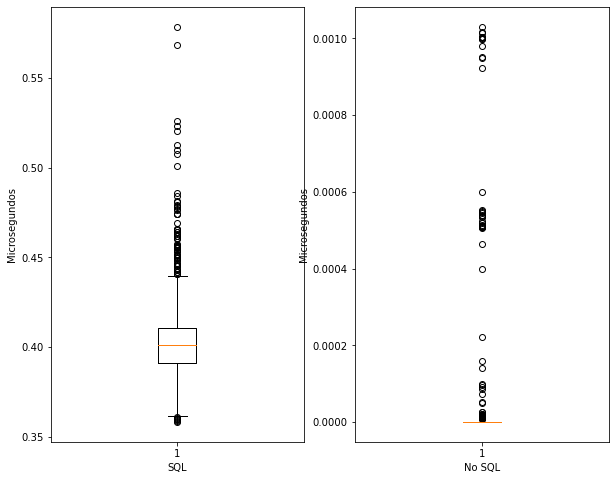

In [26]:
box_plots(l_sql,l_nosql,name='2')

### Tercer consulta

Obtener el acumulado de precipitación para cada estación (punto de la retícula).

In [27]:
sql1 = "SELECT Estaciones, SUM(precipitacion) FROM INFO_METEO3 GROUP BY Estaciones "
l_sql = np.zeros(nro_iter)
for i in range(0,nro_iter):
    t11 = time()
    cursor.execute(sql1)
    t22 = time()
    t22-t11
    l_sql[i] = t22-t11

tot_sql = sum(l_sql)
pro_sql = tot_sql/nro_iter

In [28]:
np.savetxt('query3_sql.txt',np.array(l_sql))

In [29]:
l_nosql = np.zeros(nro_iter)
for i in range(0,nro_iter):
    t11 = time()
    result = db.INFO_METEO3.aggregate([{"$group": {"_id":"$fila", "Suma precipitacion":{"$sum":"$Prep"}}}])
    t22 = time()
    l_nosql[i] = t22-t11

tot_nosql = sum(l_nosql)
pro_nosql = tot_nosql/nro_iter

In [30]:
np.savetxt('query3_nosql.txt',np.array(l_nosql))

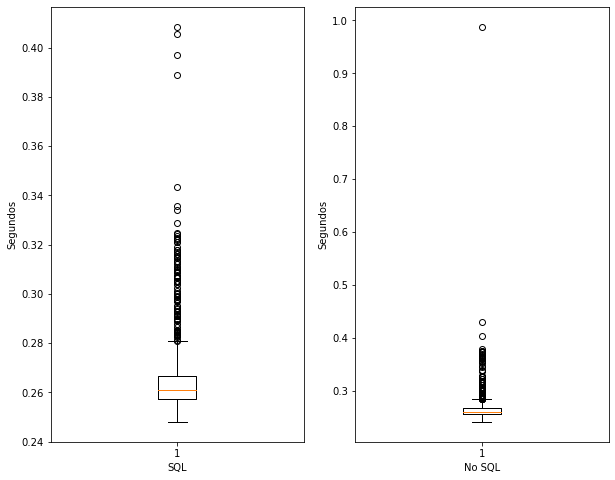

In [33]:
box_plots(l_sql,l_nosql,name='3')